## Diffusion Equations

Diffusion equations, potentially with reaction and forcing terms, are generally stated in the form

$$
\mathcal{B} := -\nabla\cdot(a\nabla u) + c u = f \quad \mathbf{x}\in\Omega
$$

where $a:\Omega\to\mathbb{R}^{d\times d}$ is a given diffusion tensor field, $c:\Omega\to\mathbb{R}$ is a given reaction scalar field and $f:\Omega\to\mathbb{R}$ is a forcing scalar field. To assure that this equation is well-defined and a unique solution exists, we must make several more assumptions

1. $\Omega\subset\mathbb{R}^d$ is a bounded Lipschitz domain.
2. $f\in L^2(\Omega)$
3. $a=\{a_{i,j}\}_{i,j=1}^d$ with $a_{i,j}\in L^{\infty}(\Omega)$ and $a_{i,j}=a_{j,i}$
4. The diffusion tensor $a$ has non negative characteristic, i.e. $\exists\theta>0$ such that
$$
\mathbf{\zeta}^T a \mathbf{\zeta} \ge\theta|\mathbf{\zeta}|^2 > 0 \quad \forall\mathbf{0}\ne\mathbf{\zeta}\in\mathbb{R}^d
$$

The well-posedness of this problem is a given when appropriate boundary conditions are provided. We opt to provide boundary conditions in the form of Dirichlet boundary conditions given by

$$
u = g_{\text{D}} \quad\mathbf{x}\in\Gamma_{\text{D}},
$$

where $\Gamma_{\text{D}}$ is defined to be the portion of the boundary to which we assign Dirichlet boundary conditions. In ```reyna```, we currently have support for only Dirichlet boundary conditions and therfore the Dirichlet boundary is defined, $\Gamma_{\text{D}} := \partial\Omega$.


### Spatial Discretisation

For simplicity, we refer to the guide in the ```advection_reaction.ipynb``` file for creating a spatial discretisation for the computational domain. For variety, we use a different domain for this tutorial example

In [38]:
from reyna.polymesher.two_dimensional.domains import RectangleCircleDomain
from reyna.polymesher.two_dimensional.main import poly_mesher

domain = RectangleCircleDomain()
poly_mesh = poly_mesher(domain, max_iterations=10, n_points=2048)

We may now view this mesh using the ```display_mesh``` function

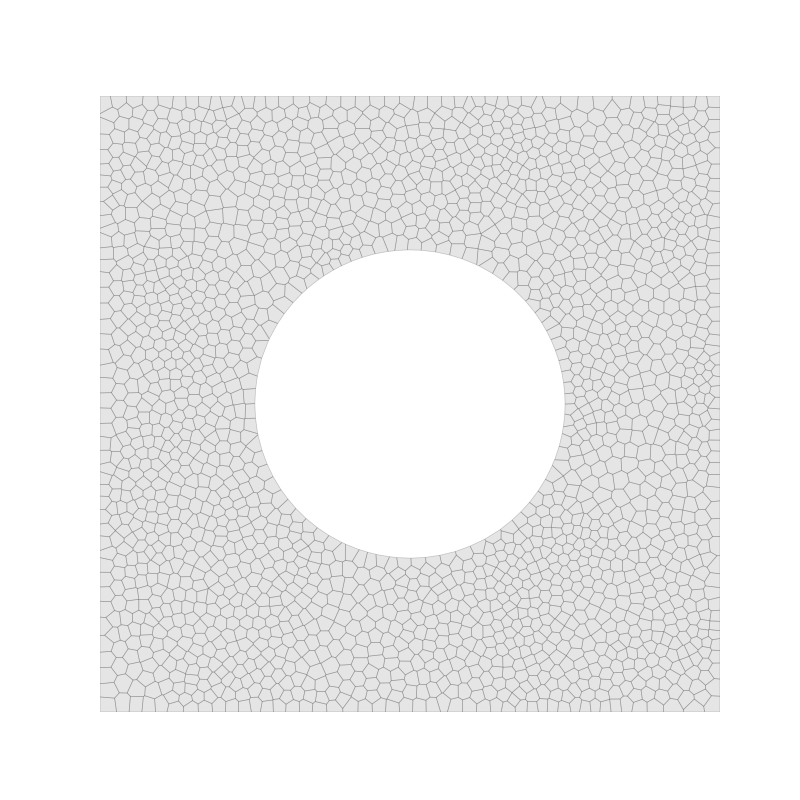

In [39]:
from reyna.polymesher.two_dimensional.visualisation import display_mesh

display_mesh(poly_mesh)

### DGFEM discretisation of $\mathcal{B}$

#### Finite element space

We let $\mathcal{T}_h$ be a partition of $\Omega$ consisting of open polytopic elements $\kappa\in\mathcal{T}_h$ such that $\overline{\Omega} = \bigcup_{\kappa\in\mathcal{T}_h}\overline{\kappa}$. We further define $h_{\kappa} = \text{diam}(\kappa)$.

From here, we may define our discontinuous finite element space $\mathbb{V}_p$ subordinate to the mesh $\mathcal{T}_h$ for a polynomial degree $p\ge0$ as

$$
\mathbb{V}_p:=\{u\in L^2(\Omega): u|_{\kappa}\in\mathbb{P}_p(\kappa), \kappa\in\mathcal{T}_h\},
$$

where $\mathbb{P}_p(\kappa)$ is defined as the space of polynomials of total degree $p$ on $\kappa$.

A notable attribute of the DGFEM method is that the local polynomials spaces $\mathbb{P}_p(\kappa)$ are defined in the physical frame, not mapped from a predefined reference element. This aids in the computation behind the scenes and enables large optimisations.

#### Preliminaries

To allow us to correctly define the spaces that some functions lie in, we first define the order-$s$ broken Sobolev space as

$$
H^s(\Omega, \mathcal{T}_h) := \{u\in L^2(\Omega) : u|_{\kappa}\in H^s(\kappa), \forall\kappa\in\mathcal{T}_h\}.
$$

Given $\kappa\in\mathcal{T}_h$, we define $v_{\kappa}^+$ to be the trace of a function $v\in H^1(\Omega, \mathcal{T}_h)$ on $\partial\kappa$ relative to $\kappa$. Letting $\kappa_i$ and $\kappa_j$ be two adjacent elements of $\mathcal{T}_h$. Then, for almost every $\mathbf{x}\in\partial\kappa\setminus\partial\Omega$, there exists of a unique element $\kappa'\in\mathcal{T}_h$, such that $\mathbf{x}\in\partial\kappa'$; therefore, we may define the outer trace $v_{\kappa}^-$ of $v$ on $\partial\kappa\setminus\partial\Omega$, relative to $\kappa$, as the inner trace $v_{\kappa'}^+$ relative to the element(s) $\kappa'$. This is well-defined under the assertion that the intersection of $\partial\kappa'$ and $\partial\kappa\setminus\partial\Omega$ has positive $(d-1)$-dimensional measure. For the sake of notation, when it is clear contextually to which element the quantities $v_k^{\pm}$ correspond to, we omit the subscript $\kappa$.

For any (not necessarily unique) elemental face $F\subset\partial\kappa_i\cap\partial\kappa_j$ and a function $v:\Omega\to\mathbb{R}$ that may be discontinuous across $F$ but sufficiently smooth inside both elements $\kappa_i$ and $\kappa_j$, we define the jump $\left\lbrack\!\left\lbrack v\right\rbrack\!\right\rbrack$ and average $\lbrace v \rbrace$ of $v$ across $F$ as

$$
\left\lbrack\!\left\lbrack v\right\rbrack\!\right\rbrack = v_{\kappa_i}^+\mathbf{\nu_{\kappa_i}} + v_{\kappa_j}^+\mathbf{\nu_{\kappa_j}}, \quad \lbrace v \rbrace = \frac{1}{2} (v_{\kappa_i}^+ + v_{\kappa_j}^+),
$$

respectively. Similarly, for a vector valued function $\mathbf{w}:\Omega\to\mathbb{R}^d$, piecewise smooth on $\mathcal{T}_h$, we define the jump and average as

$$
\left\lbrack\!\left\lbrack \mathbf{w}\right\rbrack\!\right\rbrack = \mathbf{w}_{\kappa_i}^+\cdot\mathbf{\nu_{\kappa_i}} + \mathbf{w}_{\kappa_j}^+\cdot\mathbf{\nu_{\kappa_j}}, \quad \lbrace \mathbf{w} \rbrace = \frac{1}{2} (\mathbf{w}_{\kappa_i}^+ + \mathbf{w}_{\kappa_j}^+).
$$

For consistently, if $F\in\partial\Omega$ is a boundary facet for the element $\kappa\in\mathcal{T}_h$, we define the jump and averages as

$$
\left\lbrack\!\left\lbrack v\right\rbrack\!\right\rbrack = v_{\kappa}^+\mathbf{\nu_{\kappa}}, \quad \left\lbrack\!\left\lbrack \mathbf{w}\right\rbrack\!\right\rbrack = \mathbf{w}_{\kappa}^+\cdot\mathbf{\nu_{\kappa}}, \quad \lbrace v \rbrace = v_{\kappa}^+, \quad \lbrace \mathbf{w} \rbrace = \mathbf{w}_{\kappa}^+
$$

where $\mathbf{\nu_{\kappa}}$ is the corresponding normal to $\kappa$ on $F\subset\partial\Omega$.

Finally, for $v\in H^1(\Omega, \mathcal{T}_h)$, we define the broken gradient $\nabla_hv$ element-wise by $(\nabla_hv)|_{\kappa} = \nabla(v|_{\kappa})$, $\kappa\in\mathcal{T}_h$.


#### The Discrete Bilinear Form

We may now define our discontinuous Galerkin finite element scheme; find $u_h\in\mathbb{V}_p$ such that

$$
B_{\text{d}}(u_h, v_h) = \ell(v_h)\quad\forall v_h\in\mathbf{V}_p,
$$

where $B_{\text{d}}:\mathbf{V}_p\times\mathbf{V}_p\to\mathbb{R}$ is defined as

$$
B_{\text{d}}(u, v) =\sum_{\kappa\in\mathcal{T}_h}\bigg(\int_{\kappa}a\nabla u\cdot\nabla v + cuv d\mathbf{x}\bigg) - \int_{\Gamma_{\text{int}}\cup\Gamma_{\text{D}}}\Big(\lbrace a\nabla u \rbrace\cdot\left\lbrack\!\left\lbrack v\right\rbrack\!\right\rbrack + \lbrace a\nabla v \rbrace\cdot\left\lbrack\!\left\lbrack u\right\rbrack\!\right\rbrack - \sigma\left\lbrack\!\left\lbrack u\right\rbrack\!\right\rbrack\cdot\left\lbrack\!\left\lbrack v\right\rbrack\!\right\rbrack\Big)ds
$$

where we define $\Gamma_{\text{int}}$ and $\Gamma_{\text{D}}$ to be the union of the interior facets and the union of Dirichlet boundary facets (in this case $\Gamma_{\text{D}} = \partial\Omega$). Finally, we define the linear functional $\ell: \mathbb{V}_p\to\mathbb{R}$ to be

$$
\ell(v) = \int_{\Omega}fvd\mathbf{x} -\int_{\Gamma_{\text{D}}}g_{\text{D}}\left((a\nabla v)\cdot\mathbf{\nu} - \sigma v\right)ds.
$$

The function $\sigma: \Gamma_{\text{int}}\cup\Gamma_{\text{D}}\to\mathbb{R}$ denotes the discontinuity-penalisation function. More information on this and the analysis behind its determintation may be viewed in 'hp-Version Discontinuous Galerkin Methods on Polygonal and Polyhedral Meshes' by Cangiani, A. et al.

### Solving the PDE

#### Generating the mesh geometry

As before, we first need to define the geometry of the problem, we do this as follows

In [40]:
from reyna.geometry.two_dimensional.DGFEM import DGFEMGeometry

geometry = DGFEMGeometry(poly_mesh)

This object contains all the additional information the solver needs to function, including indicating which edges of the computational domain are boundary or interior facets and the normals to these corresponding edges.

#### Inputting the known data

Next, we need to define and input the functions for the diffusion tensor, reaction field and forcing terms. The accompany these (and to close the problem), we must also include a function for the boundary conditions to the problem. For the two dimensional setting we find ourselves in, each function must be able to take in a $\mathtt{numpy}$ array of 2D points i.e. of shape $(n, 2)$ and return either a $(n, 2, 2)$ array for a tensor field or a $(n,)$ array for a scalar field. This is indicated in the documentation for simplicity. One may use lambda functions and $\mathtt{numpy}$ functions to do this so long as the final function is $\mathtt{numba}$ compatible.

For this simple test case, we let the solution be given by

$$
u(x, y) = \sin(\pi x)\sin(\pi y) \quad (x, y)\in\Omega := (0, 1)^2
$$

From this, we may define our diffusion, reaction, forcing and boundary condition terms to be

In [41]:
import numpy as np

def diffusion(x):
    out = np.zeros((x.shape[0], 2, 2), dtype=np.float64)
    for i in range(x.shape[0]):
        out[i, 0, 0] = 1.0
        out[i, 1, 1] = 1.0
    return out


reaction = lambda x: np.pi ** 2 * np.ones(x.shape[0], dtype=float)
forcing = lambda x: 3.0 * np.pi ** 2 * np.sin(np.pi * x[:, 0]) * np.sin(np.pi * x[:, 1])

bcs = lambda x: np.sin(np.pi * x[:, 0]) * np.sin(np.pi * x[:, 1])


Note that defining the diffusion tensor function here is a little more complicated but achieveable with simple Python logic.

#### DGFEM solution

From this point, we can solve our PDE over our computational domain. In this example, we seek a solution in $\mathbb{V}_p$.

In [42]:
from reyna.DGFEM.two_dimensional.main import DGFEM

dg = DGFEM(geometry, polynomial_degree=1)
dg.add_data(
    diffusion=diffusion,
    reaction=reaction,
    dirichlet_bcs=bcs,
    forcing=forcing
)

dg.dgfem(solve=True)

For more thorough information on the keyword arguments for the ```DGFEM``` class methods, see the documentation and the ```advection_reaction.ipynb``` example notebook.

We may now plot our final solution using the following code.

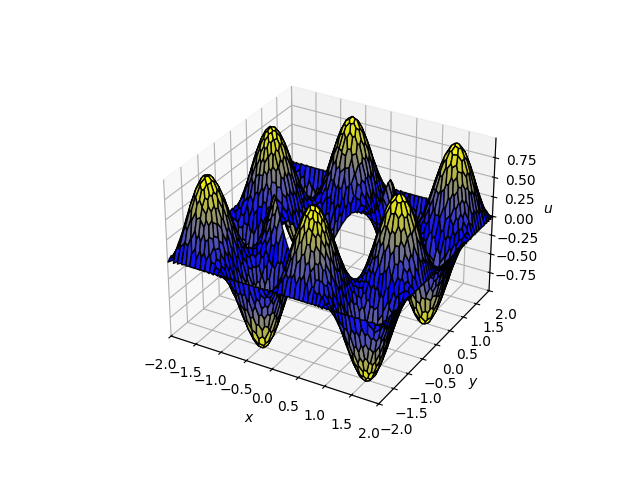

In [43]:
from reyna.DGFEM.two_dimensional.plotter import plot_DG

%matplotlib widget
plot_DG(dg.solution, dg.geometry, dg.polydegree)

### Benchmarking

We may also benchmark this code. For this, we need a little more information. Calculating the $H^1$ seminorm and dG-norm requires the input of the true solution's gradient in addition to the true solution itself. Currently this is done manually in ```reyna``` to allow precise calculation. We define the true solution and gradient of the true solution

In [44]:
solution = lambda x: np.sin(np.pi * x[:, 0]) * np.sin(np.pi * x[:, 1])


def grad_solution(x: np.ndarray):
    u_x = np.pi * np.cos(np.pi * x[:, 0]) * np.sin(np.pi * x[:, 1])
    u_y = np.pi * np.sin(np.pi * x[:, 0]) * np.cos(np.pi * x[:, 1])

    return np.vstack((u_x, u_y)).T

From here, we may calculate the errors and benchmark appropriately.

In [45]:
import time

n_elements = [32, 64, 128, 256, 512, 1024, 2048, 4096, 8192, 16384]

h_s = []
dg_norms = []
l2_norms = []
h1_norms = []

geometry_times = []
initialisation_times = []
assembly_times = []

for n_r in n_elements:

    _time = time.time()

    poly_mesh = poly_mesher(domain, max_iterations=10, n_points=n_r)
    geometry = DGFEMGeometry(poly_mesh)

    geometry_times.append(time.time() - _time)
    _time = time.time()

    dg = DGFEM(geometry, polynomial_degree=1)
    dg.add_data(
        diffusion=diffusion,
        reaction=reaction,
        dirichlet_bcs=bcs,
        forcing=forcing
    )

    initialisation_times.append(time.time() - _time)
    _time = time.time()

    dg.dgfem(solve=True)

    assembly_times.append(time.time() - _time)

    l2_error, dg_error, h1_error = dg.errors(
                                        exact_solution=solution,
                                        grad_exact_solution=grad_solution,
                                    )

    h_s.append(geometry.h)
    l2_norms.append(l2_error)
    dg_norms.append(dg_error)
    h1_norms.append(h1_error)

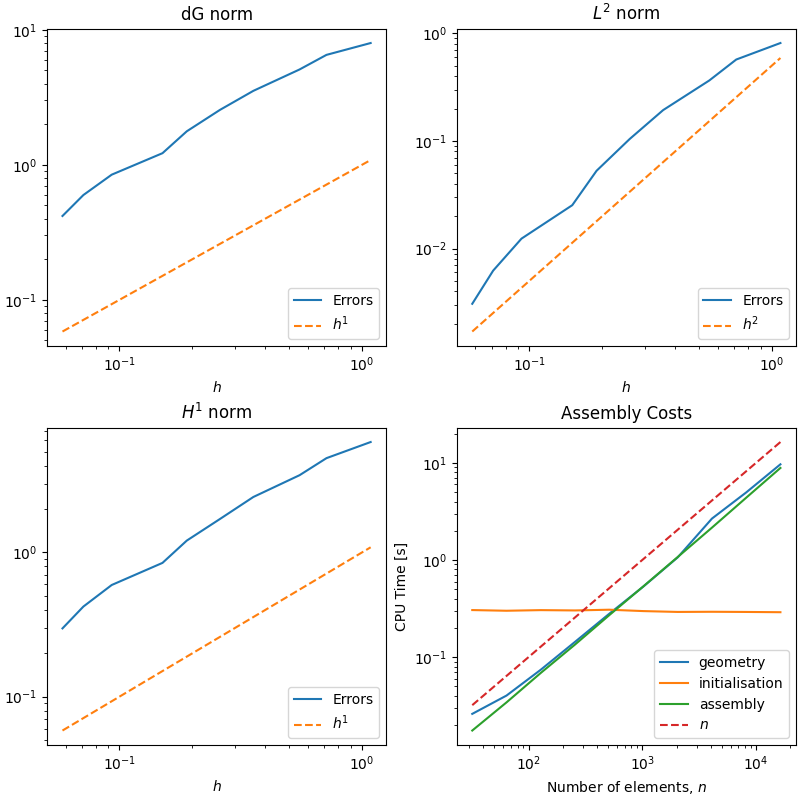

In [46]:
import matplotlib.pyplot as plt

x_ = np.linspace(h_s[-1], h_s[0], 100)
n_ = np.linspace(n_elements[-1], n_elements[0], 100)

fig, axes = plt.subplots(2, 2, figsize=(8, 8), constrained_layout=True)

axes[0, 0].plot(h_s, dg_norms, label='Errors')
axes[0, 0].plot(x_, x_ ** 1.0, linestyle='--', label=r'$h^{1}$')

axes[0, 0].legend(loc='lower right')
axes[0, 0].set_title('dG norm')
axes[0, 0].set_xscale('log')
axes[0, 0].set_yscale('log')
axes[0, 0].set_xlabel(r'$h$')

axes[0, 1].plot(h_s, l2_norms, label='Errors')
axes[0, 1].plot(x_, 0.5 * x_ ** 2.0, linestyle='--', label=r'$h^{2}$')

axes[0, 1].legend(loc='lower right')
axes[0, 1].set_title(r'$L^2$ norm')
axes[0, 1].set_xscale('log')
axes[0, 1].set_yscale('log')
axes[0, 1].set_xlabel(r'$h$')

axes[1, 0].plot(h_s, h1_norms, label='Errors')
axes[1, 0].plot(x_, x_ ** 1.0, linestyle='--', label=r'$h^{1}$')

axes[1, 0].legend(loc='lower right')
axes[1, 0].set_title(r'$H^1$ norm')
axes[1, 0].set_xscale('log')
axes[1, 0].set_yscale('log')
axes[1, 0].set_xlabel(r'$h$')

# Plotting the times
axes[1, 1].plot(n_elements, geometry_times, label='geometry')
axes[1, 1].plot(n_elements, initialisation_times, label='initialisation')
axes[1, 1].plot(n_elements, assembly_times, label='assembly')

axes[1, 1].plot(n_, 0.001 * n_, linestyle='--', label=r'$n$')

axes[1, 1].legend(loc='lower right')
axes[1, 1].set_title('Assembly Costs')
axes[1, 1].set_xscale('log')
axes[1, 1].set_yscale('log')
axes[1, 1].set_xlabel(r'Number of elements, $n$')
axes[1, 1].set_ylabel('CPU Time [s]')

plt.show()